In [ ]:
import time

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
from tqdm import tqdm

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import cross_validate

from randalo import RandALO

np.random.seed(0)
torch.manual_seed(0)

# Using RandALO with scikit-learn models

RandALO can be easily applied to a wide variety of linear models from scikit-learn, provided they were trained with twice-differentiable losses Unfortunately, this does rule out models with non-differentiable losses such as SVMs, but it does include logistic regression. Non-differentiable regularizers, on the other hand, are perfectly fine for RandALO, so we can use sparsity-inducing penalties such as the $\ell_1$ norm or elastic net penalties.

## Example 1: Lasso

To get started with RandALO, we need a large dataset with plenty of randomness, such that ALO provides a good estimate of risk and cross-validation takes longer than we'd like. We'll generate sparse ground truth coefficients and apply the lasso to solve the problem.

In [2]:
# generate a large problem
n = 10000
p = 5000
s = 500
sigma = 1.0

# we can generate our data as numpy arrays as usual
rng = np.random.default_rng(0)
X = rng.integers(0, 2, (n, p)) * 2 - 1
beta = np.zeros(p)
beta[:s] = rng.normal(0, 1 / np.sqrt(s), (s,))
y = X @ beta + rng.normal(0, sigma, (n,))

Let's now apply and compare
- standard 5-fold cross-validation as implemented in `cross_validate` from scikit-learn
- training the model from scikit-learn on the whole dataset and applying RandALO

We'll compare on the basis of both time and risk estimation.

For this problem, the risk metric we care about is mean squared error, which we will need to provide to the `RandALO` object. While everything else that we need to apply RandALO can be the ordinary `numpy` arrays that we normally use with scikit-learn, the risk metric should be a Pytorch function. Specifically, the risk function should accept `torch.Tensor` objects `y` and `y_hat` having shape `(n,)` and return a `float` value of the mean risk over `y` and `z`. We'll simply borrow an implementation of mean squared error from `torch.nn.functional` for this example.

In [3]:
# define our risk function using torch.nn.functional
def mse_risk_fun(y, y_hat):
    return F.mse_loss(y, y_hat, reduction="mean").item()


# select a meaningful range of hyperparameters
alphas = np.linspace(0.1, 1.0, 20) / np.sqrt(s)

# first compute cross-validation
# ==============================
print("Performing 5-fold CV with scikit-learn")
cv_risks = []
tic = time.monotonic()

for alpha in tqdm(alphas):
    lasso = Lasso(alpha)
    cv_results = cross_validate(lasso, X, y, cv=5, scoring="neg_mean_squared_error")
    cv_risks.append(-np.mean(cv_results["test_score"]))

toc = time.monotonic()
cv_time = toc - tic
print(f"5-fold CV computed in {cv_time:01.3f} seconds")

# next, use RandALO, and compute the true conditional risks while we're at it
# ===========================================================================
print("Applying RandALO and computing true risks")
alo_risks = []
true_risks = []
tic = time.monotonic()

for alpha in tqdm(alphas):
    lasso = Lasso(alpha)
    lasso.fit(X, y)
    alo = RandALO.from_sklearn(lasso, X, y)
    alo_risks.append(alo.evaluate(mse_risk_fun))
    true_risks.append(np.linalg.norm(lasso.coef_ - beta) ** 2 + sigma**2)

toc = time.monotonic()
alo_time = toc - tic
print(f"RandALO computed in {alo_time:01.3f} seconds")

Performing 5-fold CV with scikit-learn


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


5-fold CV computed in 47.759 seconds
Applying RandALO and computing true risks


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

RandALO computed in 27.439 seconds


RandALO was able to compute the risk estimate in just over half of the time of 5-fold CV, with minimal additional code. What's more, the risk estimate is actually closer to the true risk, while 5-fold CV is biased:

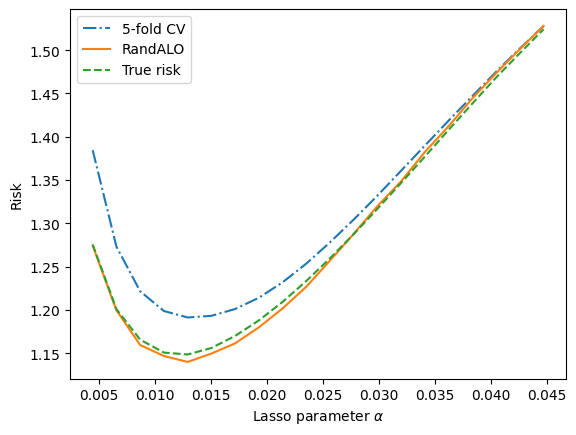

In [4]:
plt.plot(alphas, cv_risks, "-.", label="5-fold CV")
plt.plot(alphas, alo_risks, "-", label="RandALO")
plt.plot(alphas, true_risks, "--", label="True risk")

plt.xlabel(r"Lasso parameter $\alpha$")
plt.ylabel("Risk")
plt.legend()

plt.show()

## Example 2: Logistic regression

RandALO can also be applied to classification problems for logistic regression models. Let's repeat the experiment above but now for binary classification. We'll generate binary labels using the same data as before and this time generate test data to evaluate risk estimation quality since we don't have a closed-form risk expression.

In [5]:
# y = (rng.uniform(0, 1, (n,)) < scipy.special.expit(5 * X @ beta)).astype(float) * 2 - 1
n = 8000
p = 2000
s = 1000
X = rng.integers(0, 2, (n, p)) * 2 - 1
beta = np.zeros(p)
beta[:s] = rng.normal(0, 1 / np.sqrt(s), (s,))
y = np.sign(X @ beta)

n_test = 20000
X_test = rng.integers(0, 2, (n_test, p)) * 2 - 1
y_test = np.sign(X_test @ beta)

Note that we have to use $\pm 1$ binary labels with RandALO.

We'll use the zero–one loss as our risk funciton, which we'll have to define.
For classification, the value of `y_hat` passed to the risk function is not the output labels, but instead the real-valued output from the `decision_function` method from scikit-learn. 

In [6]:
def zero_one_risk_fun(y, z):
    return torch.mean(torch.lt(y * z, 0).float()).item()

# select model and a meaningful range of hyperparameters
kwargs = {
    "penalty": "l1",
    "solver": "liblinear",
}
Cs = np.logspace(-2, 1, 10)

# first compute cross-validation
# ==============================
print("Performing 5-fold CV with scikit-learn")
cv_risks = []
tic = time.monotonic()

for C in tqdm(Cs):
    lr = LogisticRegression(C=C, **kwargs)
    cv_results = cross_validate(lr, X, y, cv=5, scoring="accuracy")
    cv_risks.append(1 - np.mean(cv_results["test_score"]))

toc = time.monotonic()
cv_time = toc - tic
print(f"5-fold CV computed in {cv_time:01.3f} seconds")

# next, use RandALO, and hold onto the models to evaluate test error
# ==================================================================
print("Applying RandALO")
alo_risks = []
models = []
tic = time.monotonic()

for C in tqdm(Cs):
    lr = LogisticRegression(C=C, **kwargs)
    lr.fit(X, y)
    alo = RandALO.from_sklearn(lr, X, y)
    alo_risks.append(alo.evaluate(zero_one_risk_fun))
    models.append(lr)

toc = time.monotonic()
alo_time = toc - tic
print(f"RandALO computed in {alo_time:01.3f} seconds")

# evaluate test error
test_risks = []
for model in models:
    test_risks.append(1 - model.score(X_test, y_test))

Performing 5-fold CV with scikit-learn


100%|██████████| 10/10 [01:13<00:00,  7.40s/it]


5-fold CV computed in 73.970 seconds
Applying RandALO


100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


RandALO computed in 30.726 seconds


This time we can compute the RandALO risk estimates in less than half the time of 5-fold CV. And once again, our risk estimates are just as good if not better.

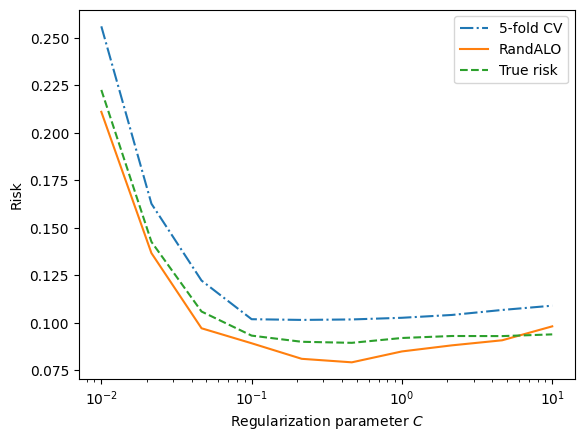

In [7]:
plt.plot(Cs, cv_risks, "-.", label="5-fold CV")
plt.plot(Cs, alo_risks, "-", label="RandALO")
plt.plot(Cs, test_risks, "--", label="True risk")

plt.xlabel(r"Regularization parameter $C$")
plt.ylabel("Risk")
plt.xscale("log")
plt.legend()

plt.show()